In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


In [2]:
df = pd.read_csv('ds_salaries.csv')

df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


Проанализируем дата сет(EDA) и "Причешим" дата сет(Preprocessing data set)

In [3]:
df.shape

(3755, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [5]:
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,3755.000000,3.755000e+03,3755.000000,3755.000000
mean,2022.373635,1.906956e+05,137570.389880,46.271638
std,0.691448,6.716765e+05,63055.625278,48.589050
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,1.000000e+05,95000.000000,0.000000
50%,2022.000000,1.380000e+05,135000.000000,0.000000
75%,2023.000000,1.800000e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


In [6]:
df.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [7]:
df.duplicated().sum()

np.int64(1171)

In [8]:
# Удалим дубликаты
df = df.drop_duplicates()

Анализ целевой переменной

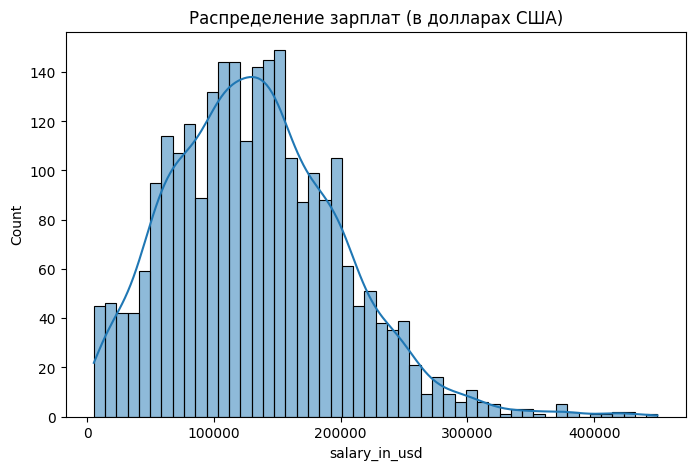

In [9]:
plt.figure(figsize=(8,5))
sns.histplot(df['salary_in_usd'], bins=50, kde=True)
plt.title("Распределение зарплат (в долларах США)")
plt.show()

Мы видим правостороннюю скошенность и длинный хвост

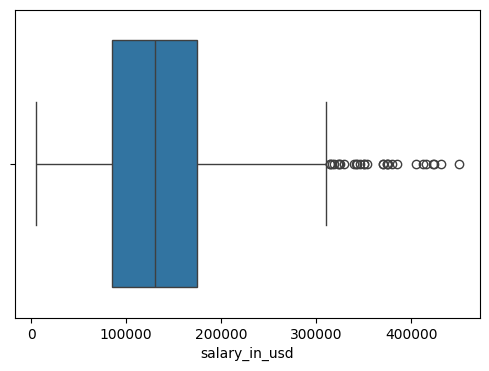

In [10]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['salary_in_usd'])
plt.show()

Также мы наблюдаем много выбросов в высоких значениях

Линейная регрессия в исходном виде будет: нестабильной и сильно ошибаться на хвосте
а также в метриках MSE/RMSE будут доминировать большие зарплаты

Чтобы этого избежать мы масштабируем целевой признак через логарифмирование(для экономических показателей лучше логарифмировать, т.к. это нелинейное масштабирование)

In [11]:
df['log_salary'] = np.log1p(df['salary_in_usd'])

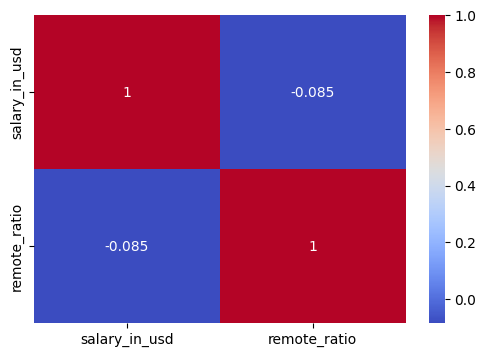

In [12]:
plt.figure(figsize=(6,4))
sns.heatmap(df[['salary_in_usd', 'remote_ratio']].corr(),annot=True,cmap='coolwarm')
plt.show()

Анализ категориальных признаков

In [13]:
df['experience_level'].value_counts()

experience_level
SE    1554
MI     664
EN     270
EX      96
Name: count, dtype: int64

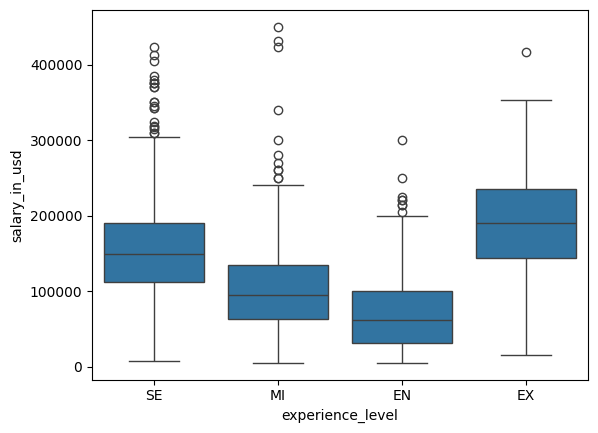

In [14]:
sns.boxplot(x='experience_level', y='salary_in_usd', data=df)
plt.show()

In [15]:
df['remote_ratio'].value_counts()

remote_ratio
100    1211
0      1186
50      187
Name: count, dtype: int64

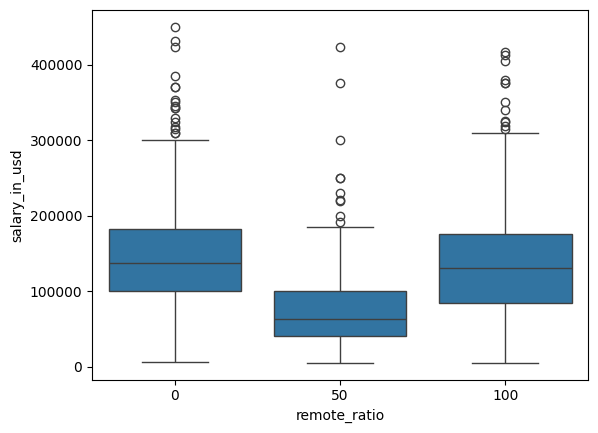

In [16]:
sns.boxplot(x='remote_ratio', y='salary_in_usd', data=df)
plt.show()

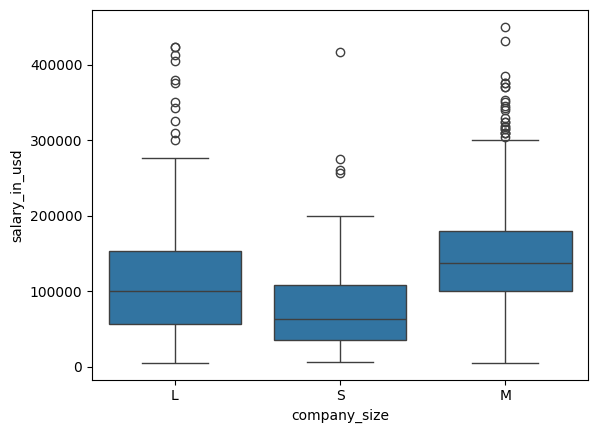

In [17]:
sns.boxplot(x='company_size', y='salary_in_usd', data=df)
plt.show()

In [18]:
df['company_location'].value_counts().head(10)

company_location
US    1929
GB     155
CA      83
IN      57
DE      55
ES      44
FR      33
BR      15
AU      14
PT      14
Name: count, dtype: int64

Инженеринг признаков

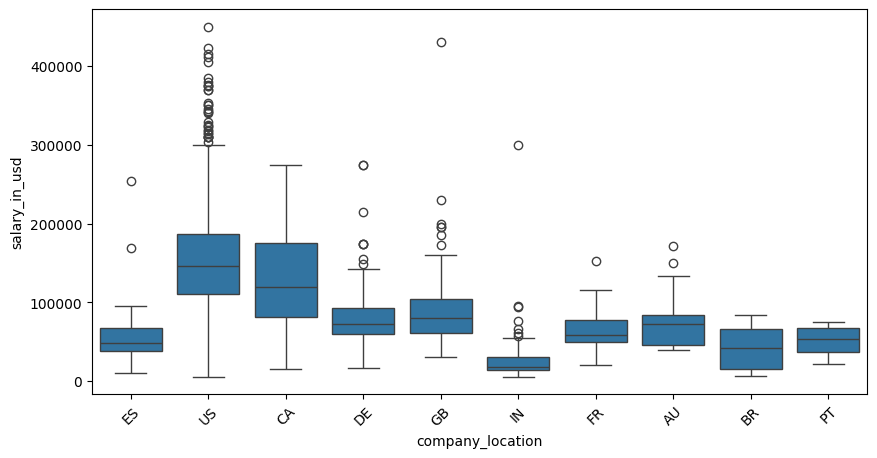

In [19]:
top_countries = df['company_location'].value_counts().head(10).index

plt.figure(figsize=(10,5))
sns.boxplot(
    x='company_location',
    y='salary_in_usd',
    data=df[df['company_location'].isin(top_countries)]
)
plt.xticks(rotation=45)
plt.show()

salary_currency - уже учтён USD
salary - дублирует salary_in_usd
job_title - очень много уникальных значений и высокий шум. Линейная регрессия будет нестабильной, лучше удалить
employee_residence - сильно коррелируе и company_location. Возможна мультиколлинеарность

In [20]:
df = df.drop(columns=['salary', 'salary_currency', 'salary_in_usd'])
df = df.drop(columns=['job_title'])
df = df.drop(columns=['employment_type'])

In [21]:
df.head()

,work_year,experience_level,employee_residence,remote_ratio,company_location,company_size,log_salary
0,2023,SE,ES,100,ES,L,11.360334
1,2023,MI,US,100,US,S,10.308986
2,2023,MI,US,100,US,S,10.146473
3,2023,SE,CA,100,CA,M,12.072547
4,2023,SE,CA,100,CA,M,11.695255


Построение Регрессии

In [22]:
num_features = [
    'work_year',
    'remote_ratio'
]
cat_features = [
    'experience_level',
    'company_location',
    'company_size'
]

# ColumnTransformer
preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

preprocessor_clf = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

# Финальный pipeline
reg_pipelines = {
    "Linear": Pipeline([
        ("prep", preprocessor_reg),
        ("model", LinearRegression())
    ]),
    "Ridge": Pipeline([
        ("prep", preprocessor_reg),
        ("model", Ridge(alpha=1.0))
    ]),
    "Lasso": Pipeline([
        ("prep", preprocessor_reg),
        ("model", Lasso(alpha=0.001))
    ])
}

clf_pipelines = {
    "LogReg": Pipeline([
        ("prep", preprocessor_clf),
        ("model", LogisticRegression(max_iter=1000))
    ]),
    "RandomForest": Pipeline([
        ("prep", preprocessor_clf),
        ("model", RandomForestClassifier(random_state=42))
    ])
}

In [23]:
# Разбиваем выборку на признаки и целевую переменную
X = df.drop(columns='log_salary')
y = df['log_salary']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y, test_size=0.2, random_state=42
)

regression_results = []

for name, pipe in reg_pipelines.items():
    pipe.fit(X_train_reg, y_train_reg)
    preds = pipe.predict(X_test_reg)

    rmse = mean_squared_error(y_test_reg, preds) ** 0.5
    mae = mean_absolute_error(y_test_reg, preds)
    r2 = r2_score(y_test_reg, preds)

    regression_results.append({
        "Model": name,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })

df['salary_class'] = pd.qcut(
    df['log_salary'],
    q=3,
    labels=[0, 1, 2]
)

X = df.drop(columns=['log_salary', 'salary_class'])
y_class = df['salary_class']

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y_class
)

classification_results = []

for name, pipe in clf_pipelines.items():
    pipe.fit(X_train_clf, y_train_clf)
    preds = pipe.predict(X_test_clf)

    classification_results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test_clf, preds),
        "Precision": precision_score(y_test_clf, preds, average='weighted'),
        "Recall": recall_score(y_test_clf, preds, average='weighted'),
        "F1": f1_score(y_test_clf, preds, average='weighted')
    })


f:\anaconda3\envs\data_science_salaries_2023\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
regression_results_df = pd.DataFrame(regression_results)
regression_results_df

,Model,RMSE,MAE,R2
0,Linear,0.460015,0.343471,0.523899
1,Ridge,0.453769,0.338691,0.536740
2,Lasso,0.452286,0.338014,0.539762


In [25]:
classification_results_df = pd.DataFrame(classification_results)
classification_results_df

,Model,Accuracy,Precision,Recall,F1
0,LogReg,0.576402,0.583113,0.576402,0.554935
1,RandomForest,0.553191,0.542619,0.553191,0.539037


Оценка моделей

В ходе экспериментов были обучены три линейные модели: Linear Regression, Ridge и Lasso. Все модели показали сопоставимое качество, однако Lasso Regression продемонстрировала наилучшие значения RMSE, MAE и R². Это связано с её способностью автоматически отбирать наиболее значимые признаки в условиях высокой размерности. Ridge Regression остаётся более стабильной альтернативой при наличии коррелированных признаков.

Оценка моделей

Для задачи классификации уровней зарплат были обучены модели Logistic Regression, Random Forest и Gradient Boosting. Logistic Regression показала наивысшую точность классификации, что свидетельствует о преимущественно линейной разделимости данных.
Gradient Boosting продемонстрировал наилучшее значение macro-F1, обеспечив более сбалансированное качество по всем классам. Это указывает на наличие локальных нелинейных зависимостей в данных.

Сохранение

In [26]:
X = df.drop(columns='log_salary')
y = df['log_salary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

final_reg_pipeline = Pipeline([
    ('prep', preprocessor_reg),
    ('model', Ridge(alpha=1.0))
])

final_clf_pipeline = Pipeline([
    ('prep', preprocessor_clf),
    ('model', LogisticRegression(max_iter=1000))
])


In [27]:
# Регрессия
final_reg_pipeline.fit(X_train_reg, y_train_reg)
joblib.dump(final_reg_pipeline, "salary_reg_model.pkl")

# Классификация
final_clf_pipeline.fit(X_train_clf, y_train_clf)
joblib.dump(final_clf_pipeline, "salary_clf_model.pkl")


f:\anaconda3\envs\data_science_salaries_2023\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['salary_clf_model.pkl']